# Decision Trees

Very fast, don't need data scaling, can be visualized and easily explained. 

Random forests almost always perform better than single trees, don't need scaling of data, but aren't good for very high-dimensional sparse data. 

Gradient boosted decision trees are often slightly more accurate than random forests, are slower to train and smaller in memory, need more parameter tuning, but faster at predicting.

Decision trees are widely used models for classification and regression. They learn a hierarchy of if/else questions, leading to a decision.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import graphviz
import sklearn
%matplotlib inline

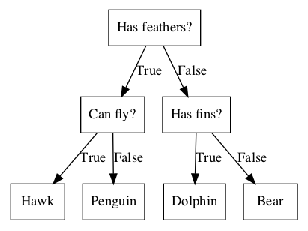

In [10]:
mglearn.plots.plot_animal_tree()

To prevent overfitting, we can pre-prune by stopping creation of the tree early, or we can post-prune by removing nodes with little information.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


In [12]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


In [13]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

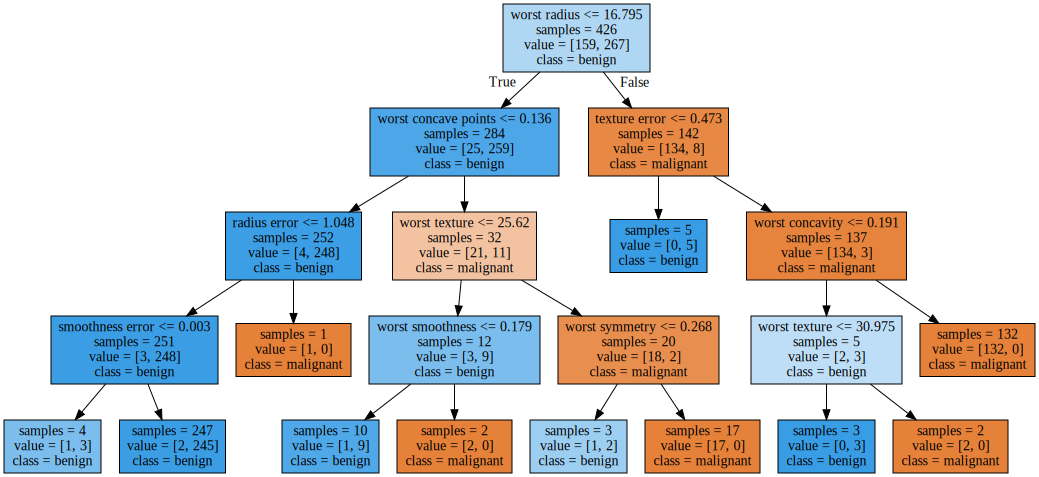

In [14]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [17]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


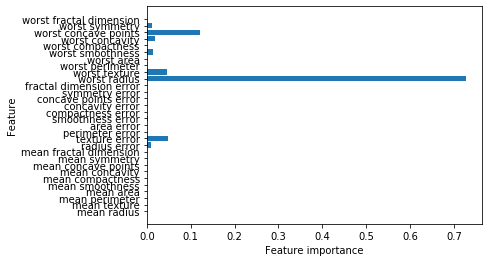

In [16]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(tree)

Feature importances: [0. 1.]


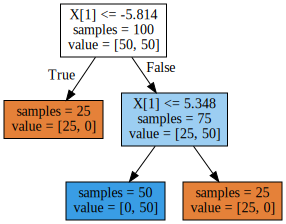

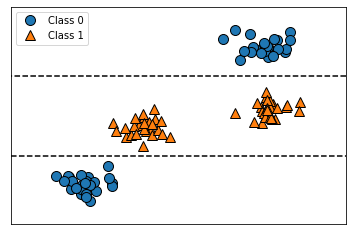

In [18]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

Text(0, 0.5, 'Price in $/Mbyte')

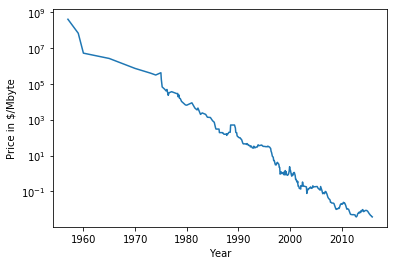

In [22]:
import pandas as pd
ram_prices = pd.read_csv("data/ram_price.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

X_train = data_train.date[:, np.newaxis]
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

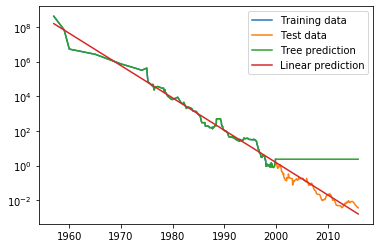

In [28]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()

Tree-based models have no ability to generate "new" responses outside of the training data; they cannot extrapolate.

Decision trees work well when features are on different scales, or there is a mix of binary and continuous features.

Even with pre-pruning, decision trees overfit often and generalize poorly.

## Ensembles of Decision Trees

Two ensemble models are effective on wide ranges of datasets for classification and regression: random forests and gradient boosted decision trees.

### Random Forests

Random forests deal with the decision tree problem of overfitting by averaging the results of a collection of decision trees, where each tree is slightly different from the others. 

In building decsion trees, we take a bootstrap sample of our data, where we randomly draw with replacement. This means the different trees in our forest work with slightly different sets of data.

When looking for tests for each node of the decision tree, we randomly select a subset of features to look through. This occurs at each node of the tree meaning we can make decisions using different subsets. This means the different nodes in our tree work with different subsets of features.

So there are two(?) levels of randomness:
<li> Bootstrap sampling at the tree level </li>
<li> Random feature selection at the node level </li>

To make predictions, a prediction is first made for every tree in the forest. For regression, we just average these results for our final prediction. For classification, each tree makes a "soft vote", giving a probability for each possible output. Then the probabilities are averaged and the highest is predicted.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

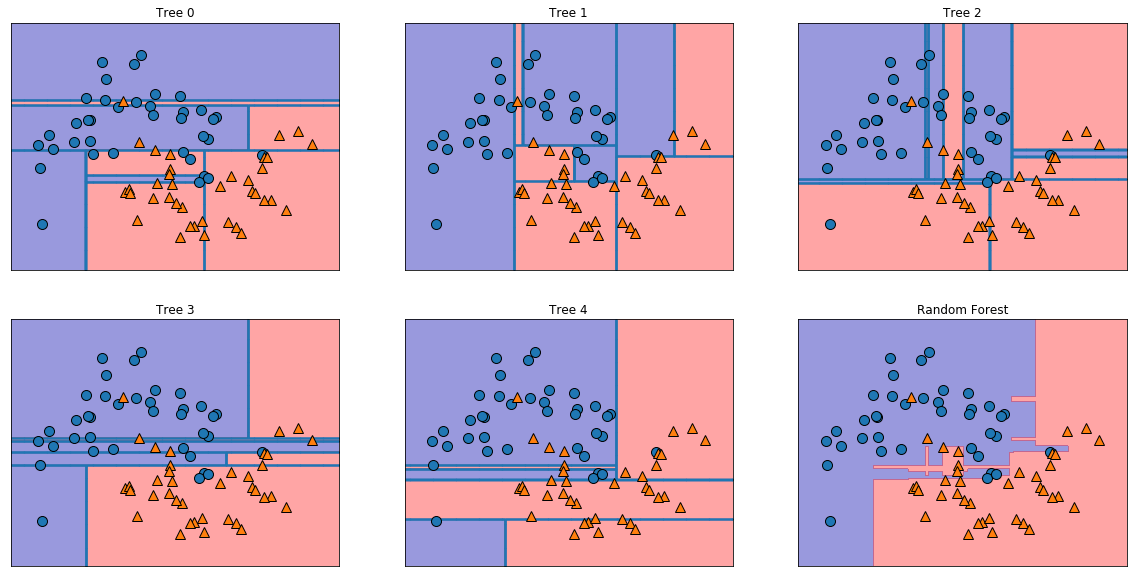

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                              alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


### Strengths, weaknesses, parameters

The n_jobs parameter allows us to adjust the number of cores to use so we can parallelize across CPU cores. 

Random forests don't usually do well on high dimensional, sparse data (i.e. text data). Random forests usually do well on very large datasets and training can be parallelized. However, they are slower and take up more memory than linear models.

Important parameters are:
<li> n_estimators (number of trees) </li>
<li> max_features (number of features each node looks through) </li>
<li> max_depth (number of levels in each tree) <li>
    
More trees is better! Use as many n_estimators as possible.
    
Smaller subsets for feature selection reduces overfitting. Stick to the default values:
<li> max_features=sqrt(n_features) for classification </li>
<li> max_features=log2(n_features) for regression </li>

### Gradient Boosted Regression Trees (Gradient Boosting Machines)

Gradient boosting works by building trees serially, each tree attempting to correct the previous one's mistakes. Strong pre-pruning is used, meaning gradient boosted trees are very shallow trees of depth 1-5 (usually). 

Gradient boosting combines many "weak learners" like shallow trees, adding more for iterative improvement. 

They are a bit more sensitive to parameter settings than random forests. An important parameter is learning_rate, which controls how strongly a tree tries to correct its predecessors. Higher learning rate or more trees increase the model complexity.

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


In [36]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [37]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


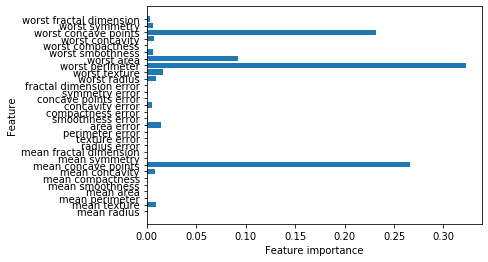

In [41]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

Try random forests for robustness and move to gradient boosting for extra performance. For large-scale problems, try the xgboost package.

### Strengths, weaknesses, parameters

Gradient boosted decision trees require careful tuning of parameters and possible long training times. Like other tree-based models it works well without scaling the data and on mixtures of feature types, but also doesn't work well on high-dimensional sparse data.

n_estimators and learning_rate are interconnected. More trees leads to a more complex model with possible overfitting. Common practice is to fit n_estimators to time and memory constraints and experiment with learning_rates. Max_depth is usually set very low (~5) for gradient boosted models.